In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import KFold
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.layers import BatchNormalization
# from tensorflow.keras import Sequential 
# from tensorflow.keras.layers import Flatten, Dense

In [2]:
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [3]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

Train: X=(60000, 28, 28, 1), y=(60000, 10)
Test: X=(10000, 28, 28, 1), y=(10000, 10)


In [4]:
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train = X_train/255.0
X_test = X_test/255.0

Unlike last time, where out first step was to flatten the model, we first want to add convolution to it, then 
let it run through an artificial neural net

for the convolutional frontend, start with a small filter (3,3) and 32 filters, followed by a max pooling layer
filter maps can be flattened to provide features to the classifier (ANN)

just like before, there are ten outputs 

Note on kernel initializers

The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.

For example in the above code, normal distribution will be used to initialise weights. You can use other functions (constants like 1s or 0s) and distributions (uniform) too. All possible options are documented here.

Additional explanation: The term kernel is a carryover from other classical methods like SVM. The idea is to transform data in a given input space to another space where the transformation is achieved using kernel functions. We can think of neural network layers as non-linear maps doing these transformations, so the term kernels is used.

Batch normalization can be used after convolutional and fully connected layers. It has the effect of changing the distribution of the output of the layer, specifically by standardizing the outputs. This has the effect of stabilizing and accelerating the learning process.

In [13]:
def models():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    #This is where the model is similar to the ANN
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    #here we are compiling the model, using the stochastic gradient descent with a learnig rate of 0.01
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model    

In [16]:
model1 = models()

In [17]:
model1.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

In [19]:
test_loss, test_acc = model1.evaluate(X_test, Y_test)
print(test_acc)

10000/10000 [==============================] - 5s 514us/step
0.9884999990463257


In [20]:
print(test_loss)

0.05574672651356791


In [25]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(2, 1, 1)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        pyplot.subplot(2, 1, 2)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
pyplot.show()

In [26]:
def evaluate_model(dataX, dataY, n_folds=5):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = models()
		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model1.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), verbose=0)
		# evaluate model
		_, acc = model1.evaluate(X_test, Y_test, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

> 98.900
> 98.920
> 98.890
> 98.890
> 98.900


C:\Users\Owner\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\Users\Owner\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


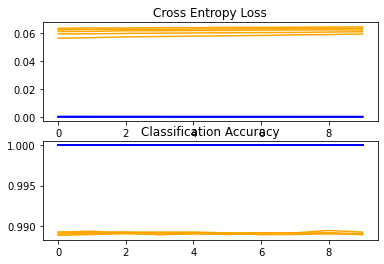

In [27]:
scores, histories = evaluate_model(X_train, Y_train)
summarize_diagnostics(histories)

In [28]:
def models2():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2,2)))
    #This is where the model is similar to the ANN
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    #here we are compiling the model, using the stochastic gradient descent with a learnig rate of 0.01
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model    

In [29]:
model2 = models2()
model2.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test), verbose=0)

In [30]:
test_loss, test_acc = model1.evaluate(X_test, Y_test)
print(test_acc)

10000/10000 [==============================] - 5s 453us/step
0.9890000224113464


In [31]:
print(test_loss)

0.06471522060223103
